In [23]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc


# Processed data, balanced training data, one hot encoding:

In [2]:
df = pd.read_csv("data/Processed_Data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [5]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade']

In [6]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142240 entries, 0 to 1142239
Columns: 124 entries, loan_amnt to sub_grade_G5
dtypes: bool(108), float64(9), int64(5), object(2)
memory usage: 257.1+ MB


In [8]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     917617
Charged Off    224623
Name: count, dtype: int64


### Train/Test Split

In [9]:
df_fully_paid = df[df['loan_status'] == 'Fully Paid']
df_charged_off = df[df['loan_status'] == 'Charged Off']


In [10]:
df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_9924\2008798936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_9924\2008798936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])


In [11]:
print(df_charged_off['issue_d'].value_counts())

issue_d
2016-03-01    8639
2015-07-01    7190
2015-10-01    6957
2015-12-01    6888
2014-10-01    6111
              ... 
2018-09-01     124
2012-03-01      88
2018-10-01      68
2018-11-01      15
2018-12-01       9
Name: count, Length: 82, dtype: int64


In [12]:
unique_issue_dates = df_charged_off['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [25]:
df_train_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] < df_charged_off['issue_d'].quantile(0.93)]
df_test_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] >= df_charged_off['issue_d'].quantile(0.93)]

In [26]:
print("Size of df_train_charged_off:", df_train_charged_off.shape)
print("Size of df_test_charged_off:", df_test_charged_off.shape)

Size of df_train_charged_off: (205966, 124)
Size of df_test_charged_off: (18657, 124)


In [27]:
df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_9924\909581260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])


In [28]:
unique_issue_dates = df_fully_paid['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [31]:
df_train_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] < df_fully_paid['issue_d'].quantile(0.92)]
df_test_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] >= df_fully_paid['issue_d'].quantile(0.92)]

In [32]:
print("Size of df_train_fully_paid:", df_train_fully_paid.shape)
print("Size of df_test_fully_paid:", df_test_fully_paid.shape)

Size of df_train_fully_paid: (835552, 124)
Size of df_test_fully_paid: (82065, 124)


In [33]:
df_train_fully_paid_resize = df_train_fully_paid.sample(n=205966, random_state=42)
df_test_fully_paid_resize = df_test_fully_paid.sample(n=74628, random_state=42)

In [34]:
print("Size of df_train_fully_paid_resize:", df_train_fully_paid_resize.shape)
print("Size of df_test_fully_paid_resize:", df_test_fully_paid_resize.shape)

Size of df_train_fully_paid_resize: (205966, 124)
Size of df_test_fully_paid_resize: (74628, 124)


In [35]:
df_train = pd.concat([df_train_fully_paid_resize, df_train_charged_off])
df_test = pd.concat([df_test_fully_paid_resize, df_test_charged_off])

In [36]:
print("Size of df_train:", df_train.shape)
print("Size of df_test:", df_test.shape)

Size of df_train: (411932, 124)
Size of df_test: (93285, 124)


In [37]:
print(df_train['loan_status'].value_counts(normalize=True) * 100)
print(df_test['loan_status'].value_counts(normalize=True) * 100)

loan_status
Fully Paid     50.0
Charged Off    50.0
Name: proportion, dtype: float64
loan_status
Fully Paid     80.0
Charged Off    20.0
Name: proportion, dtype: float64


In [38]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
360877,2500.0,36,7.35,77.60,110000.0,2017-08-01,Fully Paid,6.16,2003,8,...,False,False,False,False,False,False,False,False,False,False
781546,11000.0,36,6.46,336.94,75000.0,2018-12-01,Fully Paid,27.44,2003,10,...,False,False,False,False,False,False,False,False,False,False
444162,2000.0,36,18.94,73.26,8972.0,2018-08-01,Fully Paid,14.79,2012,9,...,False,False,False,False,False,False,False,False,False,False
1089370,14000.0,60,14.08,326.34,45000.0,2017-10-01,Fully Paid,25.20,2009,11,...,False,False,False,False,False,False,False,False,False,False
1082543,10000.0,36,7.35,310.38,37000.0,2017-10-01,Fully Paid,9.67,2003,7,...,False,False,False,False,False,False,False,False,False,False


### Random Forest Model

In [39]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

In [40]:
print(df_test['loan_status_encoded'].value_counts(normalize=True) * 100)

loan_status_encoded
1    80.0
0    20.0
Name: proportion, dtype: float64


In [42]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [43]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       1.000000       0.999995  0.999998       0.999998   
recall          0.999995       1.000000  0.999998       0.999998   
f1-score        0.999998       0.999998  0.999998       0.999998   
support    205966.000000  205966.000000  0.999998  411932.000000   

            weighted avg  
precision       0.999998  
recall          0.999998  
f1-score        0.999998  
support    411932.000000  
_________________
Confusion Matrix: 
 [[205965      1]
 [     0 205966]]

Test Result:
Accuracy Score: 62.99%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.309598      0.888469  0.629908      0.599033      0.772695
recall         0.691429      0.614528  0.629908      0.652979      0.629908
f1-score       0.427690      0.726534  0.629908      0.577112     

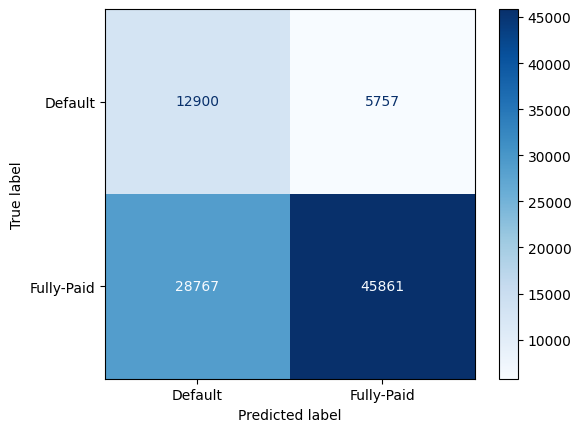

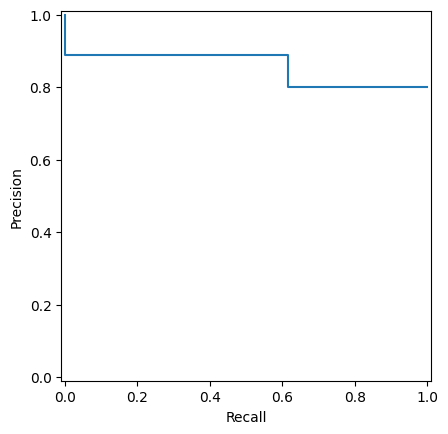

In [47]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

prec, recall, _ = precision_recall_curve(y_test, y_pred_base)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# Cleaned data, balanced training data, one hot encoding:

In [14]:
df = pd.read_csv("../data/cleaned_data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [15]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade','initial_list_status']

In [16]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220092 entries, 0 to 1220091
Columns: 130 entries, loan_amnt to initial_list_status_Whole Funded
dtypes: bool(111), float64(10), int64(7), object(2)
memory usage: 306.0+ MB


In [18]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     979419
Charged Off    240673
Name: count, dtype: int64


In [19]:
print(df.dtypes)
string_columns = df.select_dtypes(include='object').columns
if len(string_columns) > 0:
    print("The following columns have string data types:")
    for column in string_columns:
        print(column)
else:
    print("There are no string data types in the DataFrame.")


loan_amnt                                float64
term (months)                              int64
int_rate                                 float64
installment                              float64
emp_length                               float64
                                          ...   
sub_grade_G3                                bool
sub_grade_G4                                bool
sub_grade_G5                                bool
initial_list_status_Fractional Funded       bool
initial_list_status_Whole Funded            bool
Length: 130, dtype: object
The following columns have string data types:
issue_d
loan_status


### Train/Test Split

In [20]:
df_fully_paid = df[df['loan_status'] == 'Fully Paid']
df_charged_off = df[df['loan_status'] == 'Charged Off']


In [21]:
df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\2008798936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\2008798936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])


In [22]:
print(df_charged_off['issue_d'].value_counts())

issue_d
2016-03-01    9588
2015-07-01    7749
2015-10-01    7528
2015-12-01    7494
2014-10-01    6611
              ... 
2018-09-01     142
2012-03-01      90
2018-10-01      72
2018-11-01      18
2018-12-01      10
Name: count, Length: 82, dtype: int64


In [23]:
unique_issue_dates = df_charged_off['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [24]:
df_train_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] < df_charged_off['issue_d'].quantile(0.93)]
df_test_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] >= df_charged_off['issue_d'].quantile(0.93)]

In [25]:
print("Size of df_train_charged_off:", df_train_charged_off.shape)
print("Size of df_test_charged_off:", df_test_charged_off.shape)

Size of df_train_charged_off: (223598, 130)
Size of df_test_charged_off: (17075, 130)


In [26]:
df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\909581260.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\909581260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])


In [27]:
unique_issue_dates = df_fully_paid['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [30]:
df_train_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] < df_fully_paid['issue_d'].quantile(0.93)]
df_test_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] >= df_fully_paid['issue_d'].quantile(0.93)]

In [31]:
print("Size of df_train_fully_paid:", df_train_fully_paid.shape)
print("Size of df_test_fully_paid:", df_test_fully_paid.shape)

Size of df_train_fully_paid: (901673, 130)
Size of df_test_fully_paid: (77746, 130)


In [32]:
df_train_fully_paid_resize = df_train_fully_paid.sample(n=223598, random_state=42)
df_test_fully_paid_resize = df_test_fully_paid.sample(n=68300, random_state=42)

In [33]:
print("Size of df_train_fully_paid_resize:", df_train_fully_paid_resize.shape)
print("Size of df_test_fully_paid_resize:", df_test_fully_paid_resize.shape)

Size of df_train_fully_paid_resize: (223598, 130)
Size of df_test_fully_paid_resize: (68300, 130)


In [34]:
df_train = pd.concat([df_train_fully_paid_resize, df_train_charged_off])
df_test = pd.concat([df_test_fully_paid_resize, df_test_charged_off])

In [35]:
print("Size of df_train:", df_train.shape)
print("Size of df_test:", df_test.shape)

Size of df_train: (447196, 130)
Size of df_test: (85375, 130)


In [36]:
print(df_train['loan_status'].value_counts(normalize=True) * 100)
print(df_test['loan_status'].value_counts(normalize=True) * 100)

loan_status
Fully Paid     50.0
Charged Off    50.0
Name: proportion, dtype: float64
loan_status
Fully Paid     80.0
Charged Off    20.0
Name: proportion, dtype: float64


In [37]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_Fractional Funded,initial_list_status_Whole Funded
381528,18000.0,36,17.09,642.56,4.0,85000.0,2017-09-01,Fully Paid,23.51,1998,...,False,False,False,False,False,False,False,False,True,False
841463,7000.0,36,10.72,228.25,7.0,65000.0,2018-11-01,Fully Paid,18.67,2012,...,False,False,False,False,False,False,False,False,False,True
858770,11200.0,36,12.61,375.28,3.0,83000.0,2018-04-01,Fully Paid,21.24,2005,...,False,False,False,False,False,False,False,False,False,True
374280,35000.0,60,9.44,734.04,2.0,160000.0,2017-09-01,Fully Paid,15.11,1994,...,False,False,False,False,False,False,False,False,False,True
855360,12650.0,60,10.41,271.34,9.0,47000.0,2018-04-01,Fully Paid,7.02,2000,...,False,False,False,False,False,False,False,False,False,True


### Random Forest Model

In [38]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

In [39]:
print(df_test['loan_status_encoded'].value_counts(normalize=True) * 100)

loan_status_encoded
1    80.0
0    20.0
Name: proportion, dtype: float64


In [40]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [41]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                  0         1  accuracy  macro avg  weighted avg
precision       1.0       1.0       1.0        1.0           1.0
recall          1.0       1.0       1.0        1.0           1.0
f1-score        1.0       1.0       1.0        1.0           1.0
support    223598.0  223598.0       1.0   447196.0      447196.0
_________________
Confusion Matrix: 
 [[223598      0]
 [     0 223598]]

Test Result:
Accuracy Score: 62.51%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.307918      0.890217  0.625078      0.599068      0.773758
recall         0.701025      0.606091  0.625078      0.653558      0.625078
f1-score       0.427890      0.721178  0.625078      0.574534      0.662521
support    17075.000000  68300.000000  0.625078  85375.000000  85375.000000
_________________
Confusion Matrix: 
 [[11970  5105]
 [26904 4139

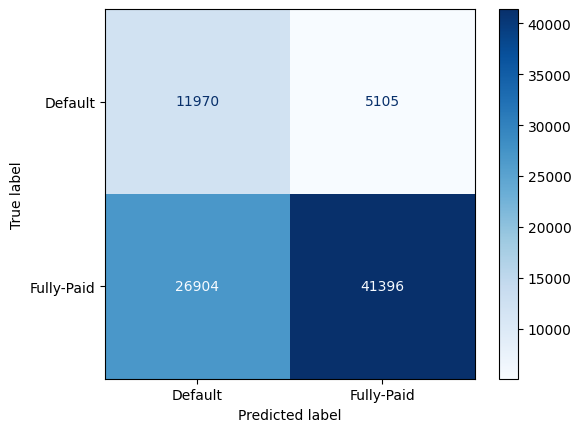

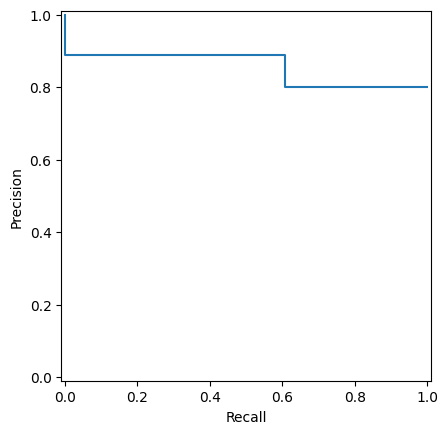

In [42]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

prec, recall, _ = precision_recall_curve(y_test, y_pred_base)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# Processed data, unbalanced data (not full set, only 60%), one hot encoding

In [2]:
df = pd.read_csv("data/Processed_Data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [3]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade']

In [4]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142240 entries, 0 to 1142239
Columns: 124 entries, loan_amnt to sub_grade_G5
dtypes: bool(108), float64(9), int64(5), object(2)
memory usage: 257.1+ MB


In [6]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     917617
Charged Off    224623
Name: count, dtype: int64


In [7]:
print(df.dtypes)
string_columns = df.select_dtypes(include='object').columns
if len(string_columns) > 0:
    print("The following columns have string data types:")
    for column in string_columns:
        print(column)
else:
    print("There are no string data types in the DataFrame.")


loan_amnt        float64
term (months)      int64
int_rate         float64
installment      float64
annual_inc       float64
                  ...   
sub_grade_G1        bool
sub_grade_G2        bool
sub_grade_G3        bool
sub_grade_G4        bool
sub_grade_G5        bool
Length: 124, dtype: object
The following columns have string data types:
issue_d
loan_status


### Train/Test Split

In [9]:
df_sample = df.sample(frac=0.6, random_state=42)

In [11]:
df_sample['issue_d'] = pd.to_datetime(df_sample['issue_d'])

In [12]:
unique_issue_dates = df_sample['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

81   2012-03-01
53   2012-04-01
39   2012-05-01
10   2012-06-01
75   2012-07-01
        ...    
77   2018-08-01
50   2018-09-01
79   2018-10-01
78   2018-11-01
80   2018-12-01
Length: 82, dtype: datetime64[ns]


In [14]:
df_train = df_sample.loc[df_sample['issue_d'] <  df_sample['issue_d'].quantile(0.9)]
df_test =  df_sample.loc[df_sample['issue_d'] >= df_sample['issue_d'].quantile(0.9)]

In [15]:
print("Size of df_train:", df_train.shape)
print("Size of df_test:", df_test.shape)

Size of df_train: (608777, 124)
Size of df_test: (76567, 124)


In [16]:
print(df_train['loan_status'].value_counts(normalize=True) * 100)
print(df_test['loan_status'].value_counts(normalize=True) * 100)

loan_status
Fully Paid     80.303954
Charged Off    19.696046
Name: proportion, dtype: float64
loan_status
Fully Paid     80.49682
Charged Off    19.50318
Name: proportion, dtype: float64


In [17]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
1069881,12000.0,36,12.62,402.14,68000.0,2017-12-01,Fully Paid,18.50,2011,11,...,False,False,False,False,False,False,False,False,False,False
459497,30000.0,36,24.85,1190.42,112000.0,2017-06-01,Fully Paid,21.98,2001,16,...,False,False,False,False,False,False,False,False,False,False
1085587,10000.0,36,11.99,332.10,68000.0,2017-10-01,Fully Paid,25.06,2005,24,...,False,False,False,False,False,False,False,False,False,False
346408,3000.0,36,9.93,96.71,53000.0,2018-01-01,Fully Paid,5.55,2007,6,...,False,False,False,False,False,False,False,False,False,False
1090156,4600.0,36,9.44,147.23,72000.0,2017-10-01,Fully Paid,8.95,1986,8,...,False,False,False,False,False,False,False,False,False,False


### Random Forest Model

In [18]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_5508\1542006363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_5508\1542006363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])


In [19]:
print(df_test['loan_status_encoded'].value_counts(normalize=True) * 100)

loan_status_encoded
1    80.49682
0    19.50318
Name: proportion, dtype: float64


In [20]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [21]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       1.000000       0.999996  0.999997       0.999998   
recall          0.999983       1.000000  0.999997       0.999992   
f1-score        0.999992       0.999998  0.999997       0.999995   
support    119905.000000  488872.000000  0.999997  608777.000000   

            weighted avg  
precision       0.999997  
recall          0.999997  
f1-score        0.999997  
support    608777.000000  
_________________
Confusion Matrix: 
 [[119903      2]
 [     0 488872]]

Test Result:
Accuracy Score: 80.42%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.490000      0.816164  0.804237      0.653082      0.752552
recall         0.091877      0.976831  0.804237      0.534354      0.804237
f1-score       0.154740      0.889299  0.804237      0.522019     

Area under Precision-Recall Curve: 0.9058228559338288


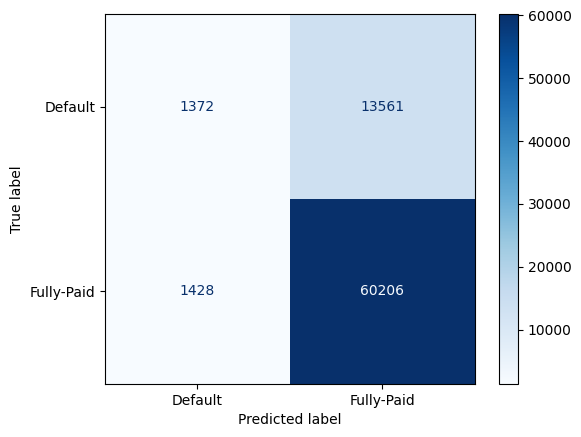

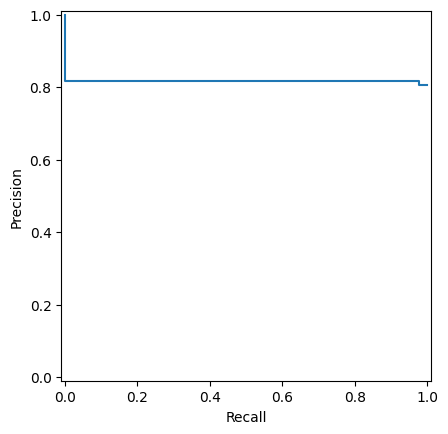

In [24]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
area_under_curve = auc(recall, prec)
print("Area under Precision-Recall Curve:", area_under_curve)

# Processed data, balanced data, ordinal and one hot encoding

# ignore below

In [49]:
# Get feature importance using RandomForest

importances = rf_base.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(feature_importance_df)


                      feature    importance
2                    int_rate  8.943332e-02
5                         dti  7.226320e-02
9                   revol_bal  6.620882e-02
10                 revol_util  6.481425e-02
3                 installment  6.352443e-02
..                        ...           ...
120              sub_grade_G4  1.502341e-04
30   purpose_renewable_energy  1.442068e-04
121              sub_grade_G5  1.135138e-04
15       home_ownership_OTHER  5.936359e-05
46              addr_state_IA  4.495982e-07

[122 rows x 2 columns]


### CV and RFE

In [36]:
# Initialize the RFECV model with cross-validation
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=42),
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy'
)

In [37]:
rfecv.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
print("Optimal number of features: {}".format(rfecv.n_features_))
print("Best features: {}".format(X_train.columns[rfecv.support_]))

In [ ]:
# Select only the important features based on RFECV
X_train_selected = X_train[X_train.columns[rfecv.support_]]
X_test_selected = X_test[X_test.columns[rfecv.support_]]

# Train a new model on only the selected features
rf_optimized = RandomForestClassifier(random_state=42)
rf_optimized.fit(X_train_selected, y_train)

# Predict and evaluate the model
y_pred_optimized = rf_optimized.predict(X_test_selected)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {accuracy_optimized}")

In [41]:
# Define a grid of parameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Tuned Model Accuracy: {accuracy_best}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 